In [1]:
# ====== import commonly used libraries ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ====== Import dataset and display unique genotypes ====== #
eyecolor_df = pd.read_csv("eyecolor_preprocessed.csv")
print("Unique values per SNP:")
snp_columns = [col for col in eyecolor_df.columns if col.startswith('rs') or col.startswith('i')]
for rsid in snp_columns:
    print(rsid, eyecolor_df[rsid].unique())

Unique values per SNP:
rs12913832 ['GG' 'AG' 'AA' nan 'G' '--' 'GA']
rs16891982 ['GG' 'CG' 'CC' nan 'TT' '--' 'GC']
rs12203592 ['CC' 'CT' nan 'TT' 'CG' 'TC' 'C' '--' 'GG']
rs12896399 ['GT' 'GG' 'TT' nan 'AA' 'CC' 'TG' '--' 'AC']
rs6119471 [nan 'CC']
rs35866166 [nan 'TT']
rs62538956 [nan 'TT']
rs1289469 [nan 'GG']
rs1126809 ['--' 'GG' 'AG' nan 'AA' '0' 'GA']
rs1426654 ['AA' 'AG' nan 'GG' 'GA' 'A' '--']
rs1800407 ['CC' 'CT' 'TC' nan 'TT' 'GG' 'C' '--' 'AG']
rs1393350 ['GG' 'AG' nan 'AA' 'GA' 'G' '--']
rs1408799 ['TT' 'CT' 'CC' nan 'GG' 'TC' 'C' '--' 'AG']
rs1800401 ['GG' 'AG' nan 'CC' 'AA' 'GA' 'G' '--']
rs7174027  [nan 'AG']
rs3794604 ['CT' 'CC' 'TT' nan 'GG' 'TC' '0' 'AG' 'C' '--']
rs4778241 ['CC' 'AC' 'AA' nan 'C' '--' 'CA']
rs1129038 ['TT' 'CT' 'CC' nan 'TC' 'GG' '0' 'T' '--' 'AG']
rs1667394 ['TT' 'CT' 'CC' nan 'TC' 'GG' 'AA' 'AG' 'T' '--']
rs916977 ['CC' nan 'CT' 'TT' 'GG' 'TC' 'AG' 'C' '--' 'AA']
rs11636232 [nan 'TT' 'CT' 'CC' 'GG' 'TC' '--' '0' 'T']
rs7174027 ['GG' 'AG' 'AA' 'CC' 

In [3]:
# ====== Pre-process the data using DataProcessor ====== #
from data_processor import DataProcessor

# Initialize data processor
data_processor = DataProcessor("eyecolor_preprocessed.csv", "eyecolor_snps.csv")

# Run full pipeline
data_processor.load_data()
data_processor.remove_duplicates()
data_processor.define_snp_columns()
data_processor.standardize_genotypes()
data_processor.clean_columns(cutoff=3)
data_processor.clean_rows(cutoff=3)
data_processor.save_cleaned()

Sample size: 1805
Columns: ['user num', 'ID-number', 'eye_color', 'rs12913832', 'rs16891982', 'rs12203592', 'rs12896399', 'rs6119471', 'rs35866166', 'rs62538956', 'rs1289469', 'rs1126809', 'rs1426654', 'rs1800407', 'rs1393350', 'rs1408799', 'rs1800401', 'rs7174027 ', 'rs3794604', 'rs4778241', 'rs1129038', 'rs1667394', 'rs916977', 'rs11636232', 'rs7174027', 'rs7495174', 'rs7183877', 'rs1800411', 'rs1498519', 'rs977588', 'rs12593929', 'rs3935591', 'rs7170852', 'rs2238289', 'rs3940272', 'rs8028689', 'rs2240203', 'rs11631797', 'rs35264875']
Sample size after removing duplicates: 1745
SNP columns: ['rs12913832', 'rs16891982', 'rs12203592', 'rs12896399', 'rs6119471', 'rs35866166', 'rs62538956', 'rs1289469', 'rs1126809', 'rs1426654', 'rs1800407', 'rs1393350', 'rs1408799', 'rs1800401', 'rs7174027 ', 'rs3794604', 'rs4778241', 'rs1129038', 'rs1667394', 'rs916977', 'rs11636232', 'rs7174027', 'rs7495174', 'rs7183877', 'rs1800411', 'rs1498519', 'rs977588', 'rs12593929', 'rs3935591', 'rs7170852', 'r

In [4]:
# ====== Standardization and Grouping ====== #
# Import genotype processor
from genotype_processor import GenotypeProcessor

eyecolor_cleaned = pd.read_csv('eyecolor_cleaned.csv')
snp_cols = [col for col in eyecolor_cleaned.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(eyecolor_cleaned,
                                       'eye_color',
                                       snp_cols=snp_cols)

# Print unique values based on "eye_color" col.
genotype_processor.print_unique_traits('eye_color')

Unique eye_color: ['blue-green' 'brown' 'Brown' 'blue-grey' 'green' 'Hazel' 'hazel' 'blue'
 'Blue' 'brown-green' 'Dark blue' 'Green' 'Blue-green' 'Light-mixed Green'
 'Hazel/Light Brown' 'Dark brown' 'green-brown'
 'Blue-grey; broken amber collarette'
 'indeterminate brown-green with a subtle grey caste' 'blue-green '
 'Changes blue/green/grey' 'gray-blue' 'Blue-grey' 'Brown-green'
 'Green-brown' 'Brown-(green when external temperature rises)'
 'one brown one green' 'Brown inner, dark green outer' 'Blue/gray'
 'Hazel/light brown'
 'The very first phenotype listed is eye colour.  you have created a duplicate.  please read the list of phenotypes before adding a new one.'
 'green yellow' 'blue spot of brown' 'Gg' 'Light-mixed green'
 'Green with amber burst and gray outer ring' 'Blue/Green'
 'Green with blue halo' 'Brown green starburst' 'Blue/green' 'Amber/brown'
 'Green yellow' 'Green-gray' 'Brown with blue outer ring' 'Gray-blue'
 'Grey brown' 'Blue-green ' 'Olive-Brown ringing Burnt U

In [5]:
# === Martin–Schultz scale == #
## Blue/Blue Mixed - mostly blue/grey pigment. 
    # 1-2: blue iris (1a, 1b, 1c, 2a, 2b)
    # 3: blue-gray iris
    # 4: gray iris (4a, 4b)
    # 5: blue-gray iris with yellow/brown spots
eyecolor_mapping = {
    "Blue/Blue-Mixed": [ 
        'blue', 'Blue',
        'Dark blue', 'Dark Blue',
        'Blue spot of brown', 'blue spot of brown', 
        'Split - one side dark blue / other side light blue and green', 
        "Ice blue mixed with slate blue, with an amber pupil burst in both eyes and a brown spot adjacent to lower left pupil. eyes were green into my 20's.",
        'Light gray/blue.', 'Light Gray Blue',
        'Gray-blue', 'blue-grey',  'gray-blue', 'Blue-grey', 'Blue/gray', 'Blue grey', 'Blue/gray',
        'Dark Grayish-Blue Eyes (like a stone)',
        'Blue-grey with central heterochromia',
        'Light gray/blue. amber/med brown on sphincter. gray ring around outer edge. flecks (nevi).',
        'Light Gray/Blue. Amber/Med Brown on Sphincter. Gray ring around outer edge. Flecks (Nevi).',
        'Light gray/blue. amber/med brown on sphincter. gray ring around outer edge. flecks (nevi).',
        'Blue with yellow parts', 'Blue with yellow inner ring', 
        'blue-green', 'Blue-green', 'blue-green ', 'Blue/Green', 'Blue/green', 'Blue-green ',
        'Blue-grey; broken amber collarette',
        'Blue with a yellow ring of flecks that make my eyes look green depending on the light or my  mood     ',
        'Light blue-green',
        'blue, grey, green, changing', 'Blue, grey, green, changing', 'Changes blue/green/grey',
        'Changes with mood blue/grey/green', 'Blue/green/grey - changes with lighting and clothing',
        'Changes with mood blue/grey/green', 'Blue/green/grey - changes with lighting and clothing',
        'Blue/Green/Grey - changes with lighting and clothing',
        'Blue-green-grey'],

# Heterochromia
    "Heterochromia": ['blue-brown heterochomia', 'blue-brown heterochromia	',
                      'blue-brown heterochromia', 'one brown one green'],

# Light mixed - mostly light pigment
    # 6: gray-green iris with yellow/brown spots
    # 7: green iris
    # 8: green iris with yellow/brown spots
    # 9-10: Hazel iris / amber iris
    "Green/Light-Mixed": [
        'Dark gray, blue, green (central heterochromia), yellow/brown ring around pupil, ',
        'Light green', 'Light-mixed Green', 'Light-mixed green',
        'green', 'Green', 'Green ', 'Green with blue halo', 'Green-gray',
        'Grey and amber', 'Grey and Amber',
        'green-blue outer ring and brown flecks around iris',
        'Green-blue outer ring and brown flecks around iris',
        'Green with brown freckles', 
        'Green yellow', 'green yellow', 'Blue/green/gold',
        'Green with amber burst and gray outer ring',
        'Blue-green; amber collarette, and gray-blue ringing', 
        'Brown green starburst',
        'green-brown', 'Brown-green', 'Green-brown', 'brown-green', ' green brown',
        'hazel light green', 'Hazel light green',
        'Hazel green', 'Green-hazel', 'Green-Hazel',
        'Hazel', 'hazel',  'Hazel (brown/green)',
        'Hazel, olive green with amber starburst',
        'Hazel (light brown, dark green, dark blue)',
        'Ambar-Green', 'Ambar-green',
],

## Dark mixed - mostly brown pigment
    # 11: light-brown iris
    # 12: medium brown iris
    # 13: dark-brown iris
    # 14-15-16: dark-brown to black iris
    "Dark-Mixed/Brown": [
        'Grey brown',
        'Brown with blue outer ring',
        'Losing eye pigment as i age, currently in the light brown almost green phase',
        'light brown with dark green tint', 'Light brown with dark green tint',
        'Hazel dark green',   'Hazel/Yellow', 'Hazel/yellow',
        'Hazel/Light Brown', 'Hazel/light brown',
        'Brown inner, dark green outer',
        'indeterminate brown-green with a subtle grey caste', 
        'Indeterminate brown-green with a subtle grey caste',
        'Brown center starburst, amber and olive green, with dark gray outer ring',
        'Brown-(green when external temperature rises)',
        'Brown - Brown and green in bright sunlight', 
        'Brown - brown and green in bright sunlight',
        'Amber/Brown', 'Amber/brown', 'Brown-Amber', 'Brown-amber', 'Amber - (yellow/ocre  brown)',
        'Olive-Brown ringing Burnt Umber-Brown', 'Olive-brown ringing burnt umber-brown',
        'Brown', 'brown', 'Dark brown', 'dark brown', 'Dark brown',
        'Brown/black', 'Black']
}

In [6]:
# Remove rows with invalid type reported
print(f'Number of rows before filtering: {len(eyecolor_cleaned)}')
eyecolor_cleaned = eyecolor_cleaned[
    ~eyecolor_cleaned['eye_color'].isin(
        ['The very first phenotype listed is eye colour.  you have created a duplicate.  please read the list of phenotypes before adding a new one.',
         'Mixed', 'Gg', 'No'])]
print(f'Number of rows after filtering: {len(eyecolor_cleaned)}')

# Standardize types
eyecolor_std = genotype_processor.standardize_traits(eyecolor_mapping, 'eye_color',
                                                      'Eyecolor Standardized', eyecolor_cleaned)
eyecolor_std.to_csv('eyecolor_standardized.csv', index=False)

# Print unique types after standardization
genotype_processor.print_unique_traits('Eyecolor Standardized', eyecolor_std)

Number of rows before filtering: 1653
Number of rows after filtering: 1649
Unique Eyecolor Standardized: ['Blue/Blue-Mixed' 'Dark-Mixed/Brown' 'Green/Light-Mixed' 'Heterochromia'],


In [7]:
# Import genotype processor
from genotype_processor import GenotypeProcessor

# Load standardized data and SNP info
eyecolor_std = pd.read_csv("eyecolor_standardized.csv")
snp_info = pd.read_csv("eyecolor_snps.csv").set_index('rsid')
snp_cols = [col for col in eyecolor_std.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(eyecolor_std,
                                       'Eyecolor Standardized',
                                       snp_cols=snp_cols)

# Filter by minimum samples and impute missing genotypes
genotype_processor.filter_by_min_samples(5).impute_missing_genotypes('NN')

# Encode SNPs
eyecolor_encoded = genotype_processor.encode_snps(snp_info, effect_dosage=1, other_dosage=-1, missing_value=0)
eyecolor_encoded.head(5)


--- Trait Counts (Bottom 10, After Filtering) ---
Eyecolor Standardized
Blue/Blue-Mixed      625
Dark-Mixed/Brown     586
Green/Light-Mixed    436
Name: count, dtype: int64
-----------------------
Number of traits before filtering: 4
Number of traits after filtering:  3



,Eyecolor Standardized,rs12913832,rs16891982,rs12203592,rs12896399,rs1426654,rs1800407,rs1393350,rs1408799,rs1800401,...,rs916977,rs11636232,rs7174027,rs7495174,rs7183877,rs1800411,rs1498519,rs977588,rs8028689,rs35264875
0,Blue/Blue-Mixed,2,2,-2,0,2,-2,-2,-2,-2,...,2,0,2,2,2,2,0,0,2,0
1,Blue/Blue-Mixed,2,2,-2,0,2,-2,-2,-2,-2,...,2,2,2,2,2,0,0,2,2,0
2,Dark-Mixed/Brown,0,2,0,-2,2,-2,-2,0,0,...,0,0,0,0,2,0,0,0,0,-2
3,Dark-Mixed/Brown,-2,2,-2,-2,2,0,-2,2,-2,...,0,-2,2,2,0,0,2,-2,2,-2
4,Dark-Mixed/Brown,-2,0,-2,-2,2,-2,0,-2,-2,...,-2,-2,-2,-2,2,2,2,2,-2,0


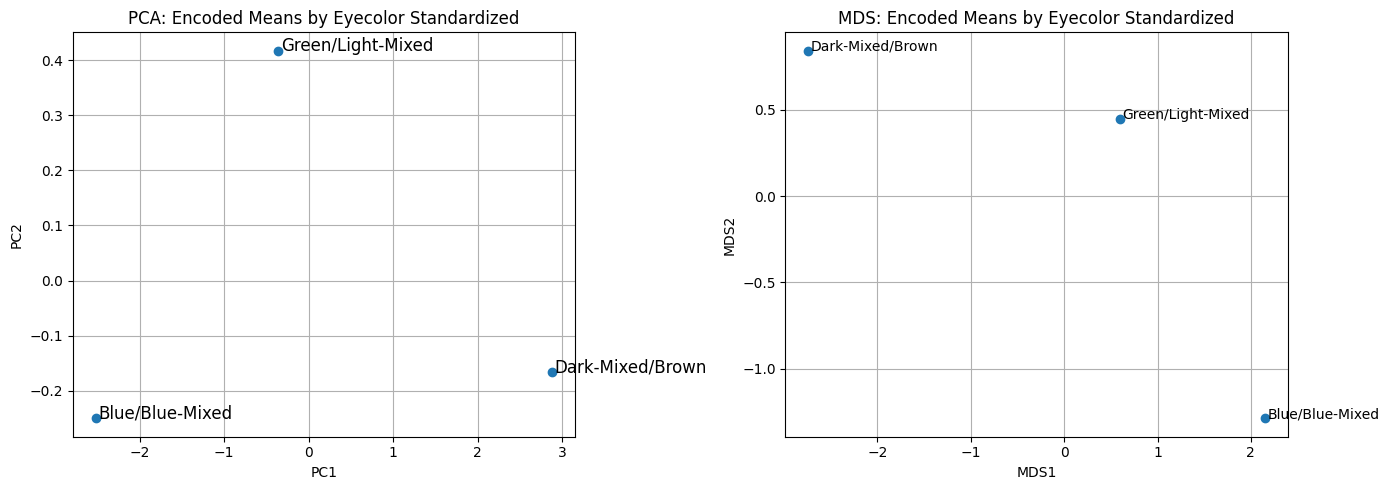

In [8]:
# Plot PCA and MDS
genotype_processor.plot_pca_mds(eyecolor_encoded, 'Eyecolor Standardized')

In [9]:
brown_blue_subset = eyecolor_encoded[~eyecolor_encoded['Eyecolor Standardized'].isin(['Green/Light-Mixed'])] 
blue_green_subset = eyecolor_encoded[~eyecolor_encoded['Eyecolor Standardized'].isin(['Dark-Mixed/Brown'])] 


=== Class Distribution (Original) ===
Blue/Blue-Mixed      Count:  625   Frequency: 0.379
Dark-Mixed/Brown     Count:  586   Frequency: 0.356
Green/Light-Mixed    Count:  436   Frequency: 0.265

=== Class Weights (Balanced) ===
Blue/Blue-Mixed      Weight: 0.878
Dark-Mixed/Brown     Weight: 0.937
Green/Light-Mixed    Weight: 1.259

=== Evaluating Logistic Regression ===
                   precision    recall  f1-score   support

  Blue/Blue-Mixed       0.79      0.87      0.83       625
 Dark-Mixed/Brown       0.83      0.81      0.82       586
Green/Light-Mixed       0.55      0.49      0.52       436

         accuracy                           0.75      1647
        macro avg       0.72      0.72      0.72      1647
     weighted avg       0.74      0.75      0.74      1647


=== Evaluating Random Forest ===
                   precision    recall  f1-score   support

  Blue/Blue-Mixed       0.77      0.83      0.80       625
 Dark-Mixed/Brown       0.78      0.88      0.83       58

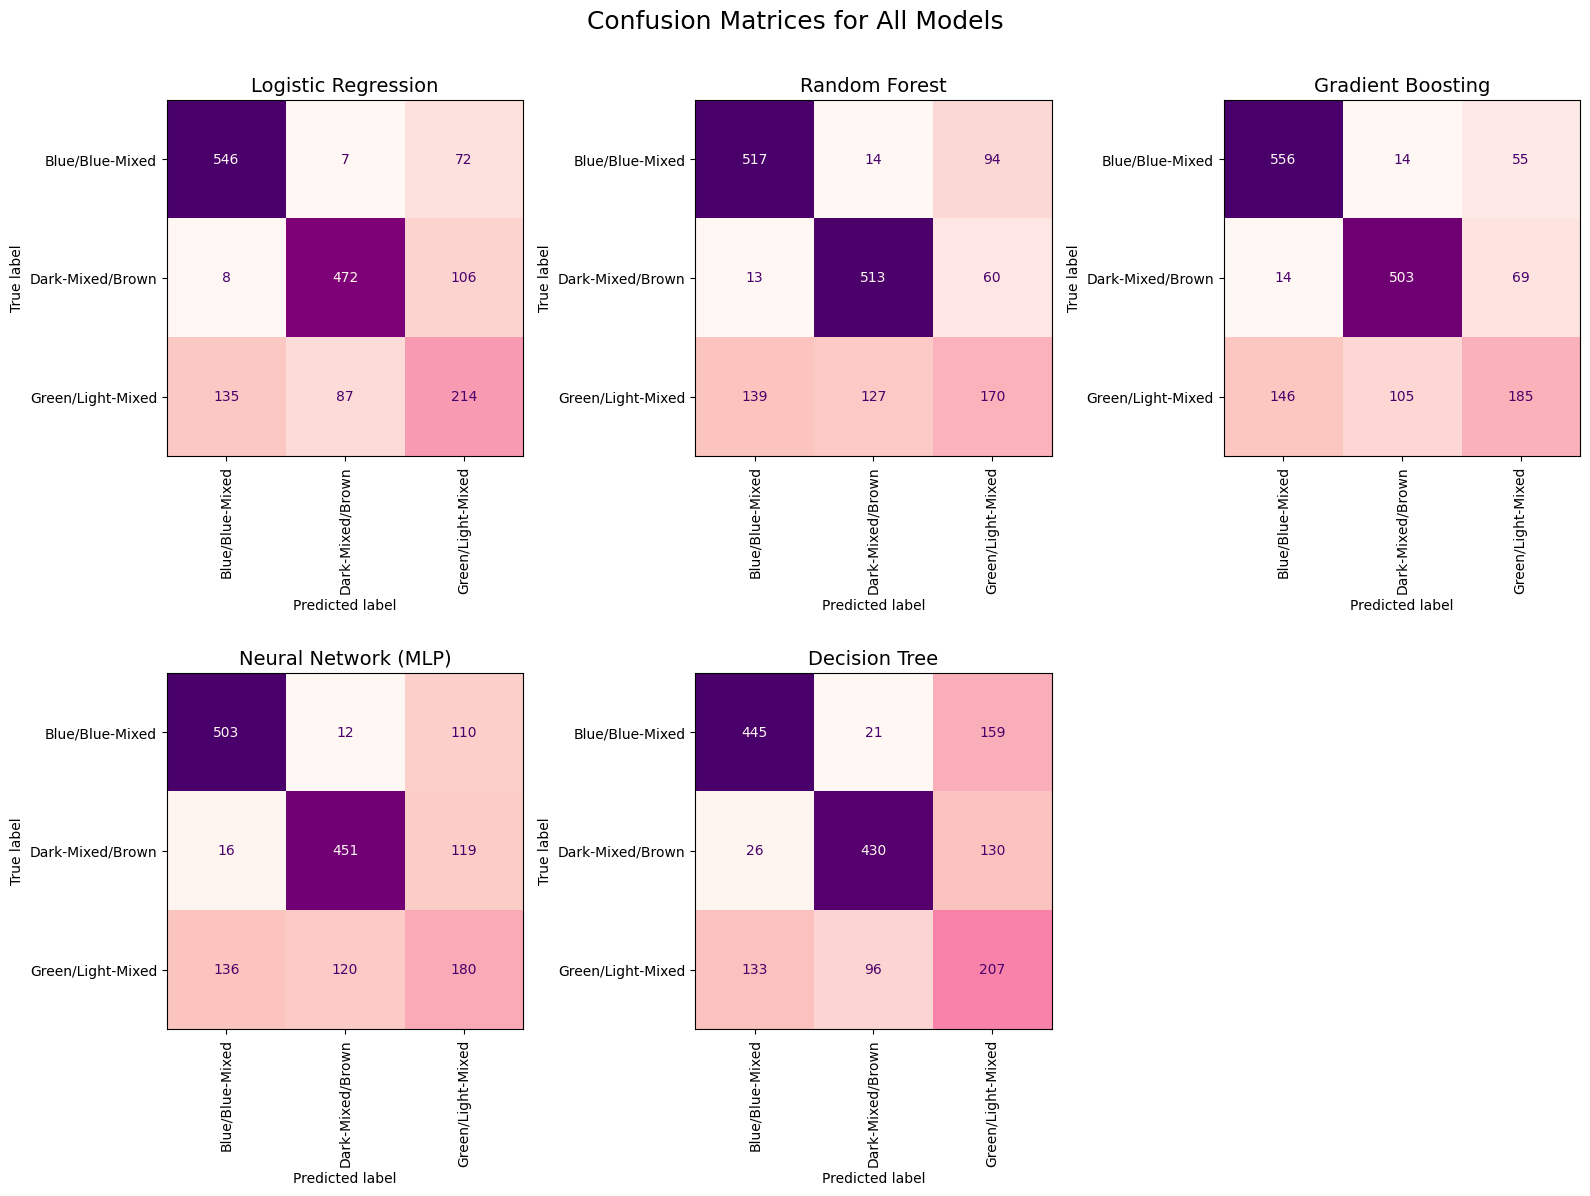


=== Model Comparison Summary ===
               Model  CV Accuracy  CV Weighted F1
 Logistic Regression         0.75            0.74
       Random Forest         0.73            0.72
   Gradient Boosting         0.76            0.74
Neural Network (MLP)         0.69            0.69
       Decision Tree         0.66            0.66
Model summary exported to: results\eyecolor_model_comparison.csv
Classification reports exported to: results\eyecolor_classification_reports.csv


In [10]:
from trait_classifier import TraitClassifier

# train models and evaluate
classifier = TraitClassifier(X=eyecolor_encoded[snp_cols],
                             y=eyecolor_encoded['Eyecolor Standardized'],
                             snp_cols=snp_cols,
                             label_name="Eyecolor Standardized",
                             out_prefix="eyecolor")

# Evaluate models
classifier.evaluate()
classifier.export_results(prefix='eyecolor')


=== Class Distribution (Original) ===
Blue/Blue-Mixed      Count:  625   Frequency: 0.516
Dark-Mixed/Brown     Count:  586   Frequency: 0.484

=== Class Weights (Balanced) ===
Blue/Blue-Mixed      Weight: 0.969
Dark-Mixed/Brown     Weight: 1.033

=== Evaluating Logistic Regression ===
                  precision    recall  f1-score   support

 Blue/Blue-Mixed       0.97      0.95      0.96       625
Dark-Mixed/Brown       0.95      0.97      0.96       586

        accuracy                           0.96      1211
       macro avg       0.96      0.96      0.96      1211
    weighted avg       0.96      0.96      0.96      1211


=== Evaluating Random Forest ===
                  precision    recall  f1-score   support

 Blue/Blue-Mixed       0.97      0.95      0.96       625
Dark-Mixed/Brown       0.95      0.97      0.96       586

        accuracy                           0.96      1211
       macro avg       0.96      0.96      0.96      1211
    weighted avg       0.96      0.9

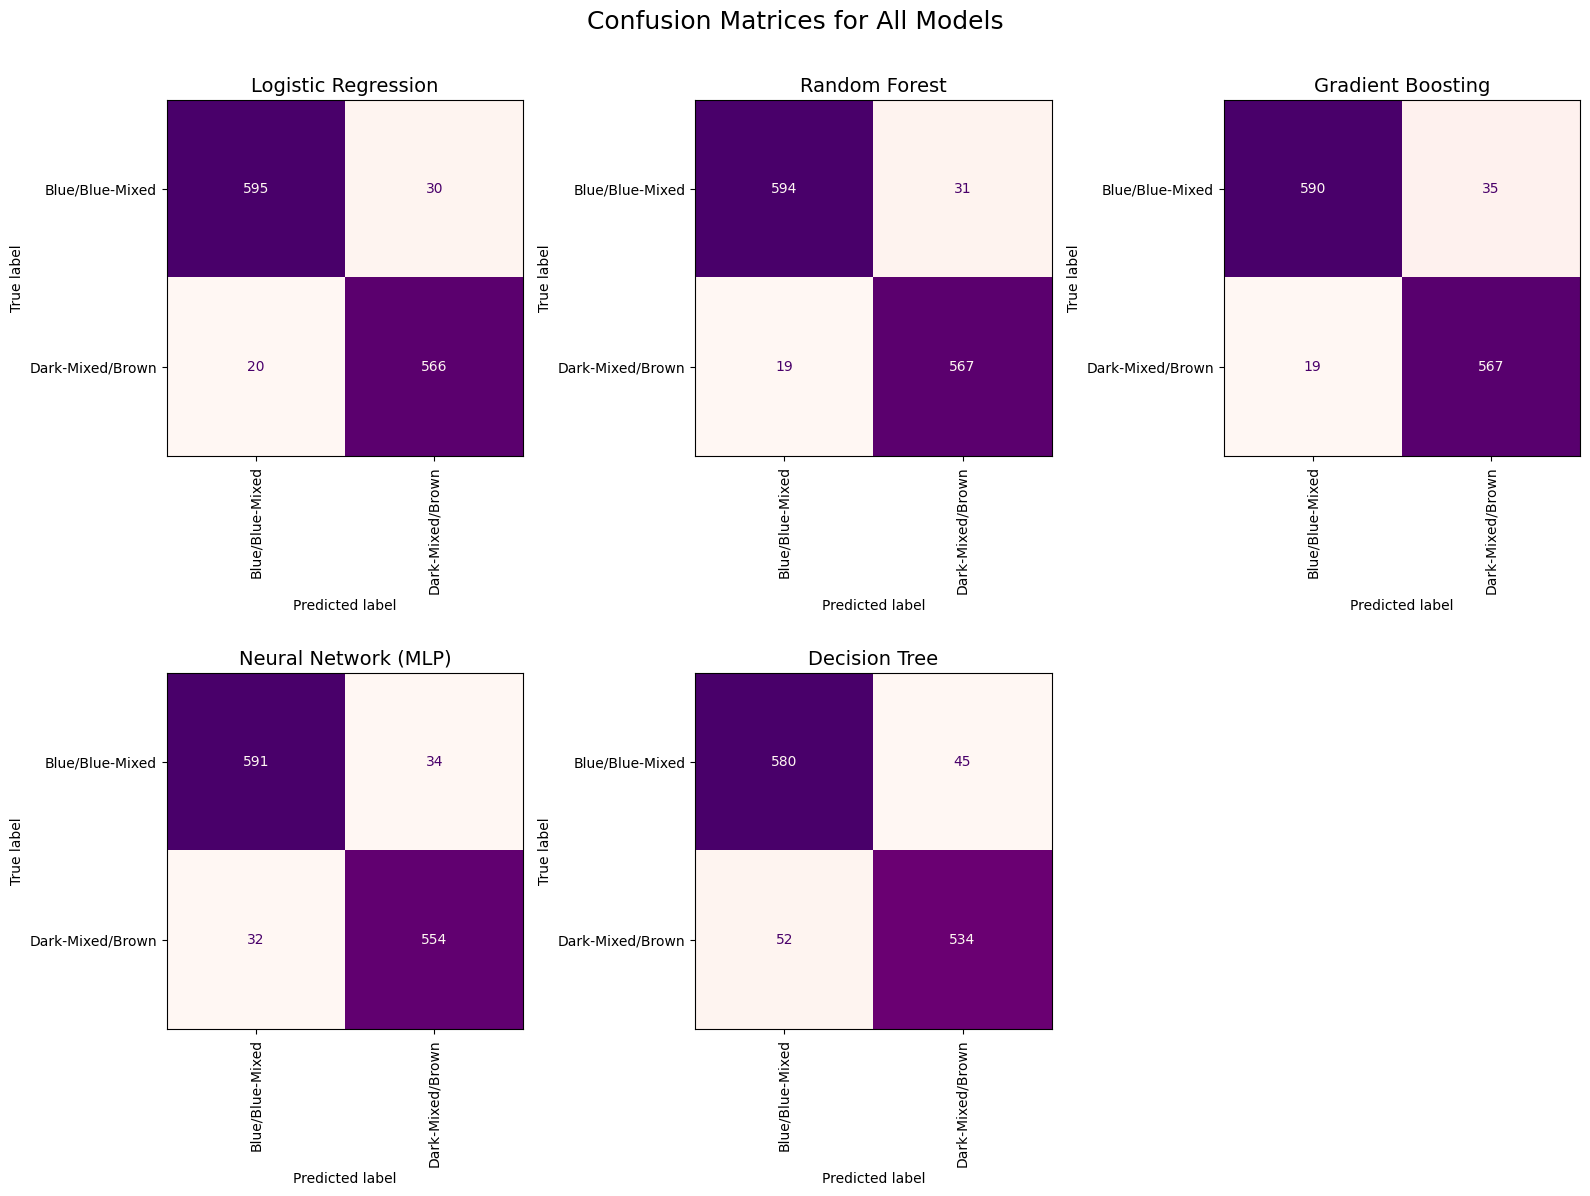


=== Model Comparison Summary ===
               Model  CV Accuracy  CV Weighted F1
 Logistic Regression         0.96            0.96
       Random Forest         0.96            0.96
   Gradient Boosting         0.96            0.96
Neural Network (MLP)         0.95            0.95
       Decision Tree         0.92            0.92
Model summary exported to: results\eyecolor_brownvsblue_model_comparison.csv
Classification reports exported to: results\eyecolor_brownvsblue_classification_reports.csv


In [11]:
# train models and evaluate
classifier_bb = TraitClassifier(X=brown_blue_subset[snp_cols],
                                y=brown_blue_subset['Eyecolor Standardized'],
                                snp_cols=snp_cols,
                                label_name="eyecolor_bb",
                                out_prefix="eyecolor_brownblue")

# Evaluate models
classifier_bb.evaluate()
classifier_bb.export_results(prefix='eyecolor_brownvsblue')


=== Class Distribution (Original) ===
Blue/Blue-Mixed      Count:  625   Frequency: 0.589
Green/Light-Mixed    Count:  436   Frequency: 0.411

=== Class Weights (Balanced) ===
Blue/Blue-Mixed      Weight: 0.849
Green/Light-Mixed    Weight: 1.217

=== Evaluating Logistic Regression ===
                   precision    recall  f1-score   support

  Blue/Blue-Mixed       0.81      0.86      0.83       625
Green/Light-Mixed       0.78      0.71      0.74       436

         accuracy                           0.80      1061
        macro avg       0.79      0.78      0.79      1061
     weighted avg       0.80      0.80      0.80      1061


=== Evaluating Random Forest ===
                   precision    recall  f1-score   support

  Blue/Blue-Mixed       0.79      0.83      0.81       625
Green/Light-Mixed       0.74      0.69      0.71       436

         accuracy                           0.77      1061
        macro avg       0.77      0.76      0.76      1061
     weighted avg       0

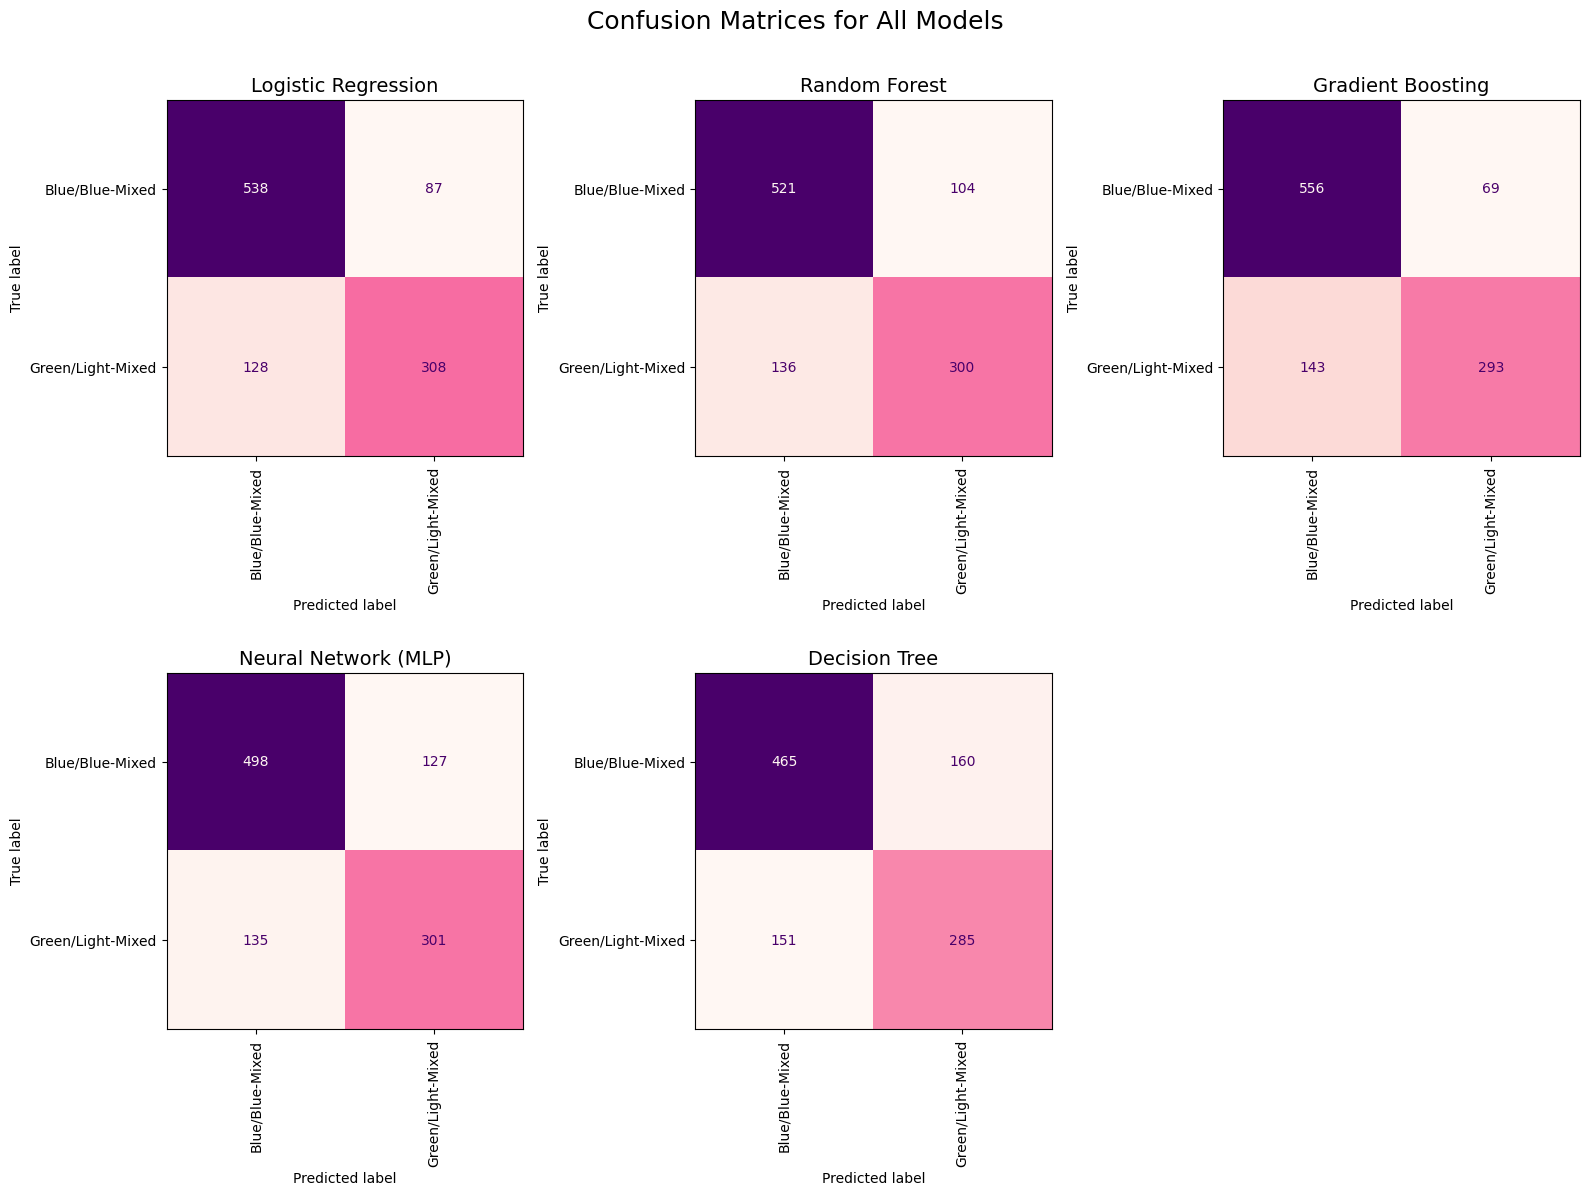


=== Model Comparison Summary ===
               Model  CV Accuracy  CV Weighted F1
 Logistic Regression         0.80            0.80
       Random Forest         0.77            0.77
   Gradient Boosting         0.80            0.80
Neural Network (MLP)         0.75            0.75
       Decision Tree         0.71            0.71
Model summary exported to: results\eyecolor_bluevsgreen_model_comparison.csv
Classification reports exported to: results\eyecolor_bluevsgreen_classification_reports.csv


In [12]:
# train models and evaluate
classifier_bg = TraitClassifier(X=blue_green_subset[snp_cols],
                             y=blue_green_subset['Eyecolor Standardized'],
                             snp_cols=snp_cols,
                             label_name="Blue/Green Subset",
                             out_prefix="eyecolor_bluegreen")

# Evaluate models
classifier_bg.evaluate()
classifier_bg.export_results(prefix='eyecolor_bluevsgreen')